In [2]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.algorithms import bipartite

## Follower

In [3]:
followersNetwork = nx.DiGraph()

In [4]:
followerGraph = nx.read_edgelist( "business/friendships.csv" , delimiter = "\t", create_using=followersNetwork)
followerGraph.number_of_nodes(), followerGraph.number_of_edges()

(32, 300)

In [5]:
#created a function to make the network graphs 
def makeGraph(graph, col, title):
    plt.figure(figsize=(15,15))
    title = title 
    plt.title(title, fontsize=14)
    plt.margins(0.01, 0.001)
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True, font_size=8, node_size=200, node_color=col, edge_color="lightblue")
    plt.show() 

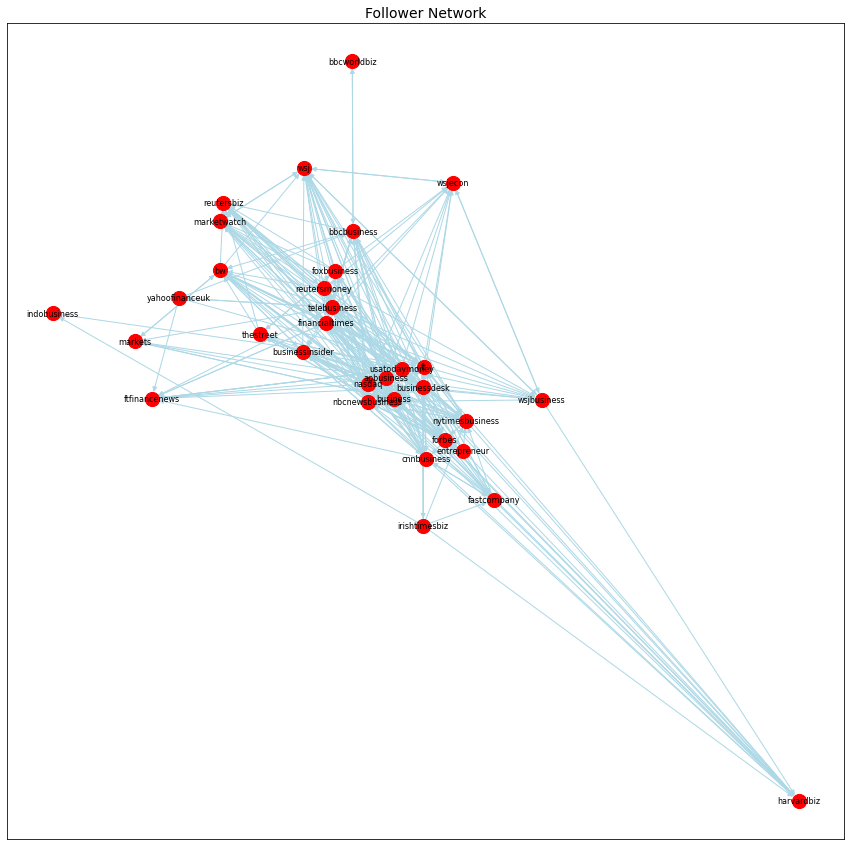

In [6]:
makeGraph(followerGraph, "red", "Follower Network")

## Reply

In [7]:
replyNetwork = nx.DiGraph()

In [8]:
file = open( "business/tweets.jsonl", "r" )
tweets = []
# process the file line-by-line
for line in file.readlines():
    line = line.strip()
    # each line contains a JSON document, representing a single tweet
    tweet = json.loads(line)
    tweets.append(tweet)
file.close()
print("Read %d tweets" % len(tweets))

Read 16000 tweets


In [9]:
networkGraph = pd.DataFrame(tweets).set_index("id")

In [10]:
columns = ['id_str','created_at', 'truncated', 'display_text_range', 'favorited', 'retweeted','possibly_sensitive', 
           'lang', 'extended_entities', 'retweeted_status', 'quoted_status_id','quoted_status_id_str',
          'quoted_status_permalink', 'quoted_status', 'geo','coordinates','contributors','is_quote_status','retweet_count', 'favorite_count','place']

In [11]:
networkGraph = networkGraph.drop(columns, axis=1)

In [12]:
networkGraph["user"][1352679491966033922]

{'id': 3108351,
 'id_str': '3108351',
 'name': 'The Wall Street Journal',
 'screen_name': 'WSJ',
 'location': 'New York, NY',
 'description': 'Sign up for our newsletters and email alerts: https://t.co/WFU7oLKkip',
 'url': 'https://t.co/GhhR6PLfem',
 'entities': {'url': {'urls': [{'url': 'https://t.co/GhhR6PLfem',
     'expanded_url': 'http://wsj.com',
     'display_url': 'wsj.com',
     'indices': [0, 23]}]},
  'description': {'urls': [{'url': 'https://t.co/WFU7oLKkip',
     'expanded_url': 'http://wsj.com/newsletters',
     'display_url': 'wsj.com/newsletters',
     'indices': [46, 69]}]}},
 'protected': False,
 'followers_count': 18452260,
 'friends_count': 1003,
 'listed_count': 118425,
 'created_at': 'Sun Apr 01 06:22:13 +0000 2007',
 'favourites_count': 1181,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 329696,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': True,
 'profile_

In [13]:
users = [] 
users=pd.json_normalize(networkGraph["user"])

In [14]:
columnsNeeded = ['id','screen_name']

In [15]:
users.drop(users.columns.difference(columnsNeeded), 1, inplace=True)

In [16]:
replyGraph = pd.concat([networkGraph.reset_index(drop=True),users.reset_index(drop=True)], axis=1)

In [17]:
replyGraph = replyGraph[replyGraph['in_reply_to_screen_name'].notna()]

In [18]:
columnsNeeded = ['screen_name','in_reply_to_screen_name']

In [19]:
replyGraph.drop(replyGraph.columns.difference(columnsNeeded), 1, inplace=True)

In [20]:
for i,row in replyGraph.iterrows():
        replyNetwork.add_node(row["in_reply_to_screen_name"])

In [21]:
for i,rows in replyGraph.iterrows():
    if rows['screen_name'] != rows['in_reply_to_screen_name']:
        replyNetwork.add_edge( rows["screen_name"], rows["in_reply_to_screen_name"]) 

In [22]:
replyNetwork.number_of_nodes(), replyNetwork.number_of_edges()

(69, 49)

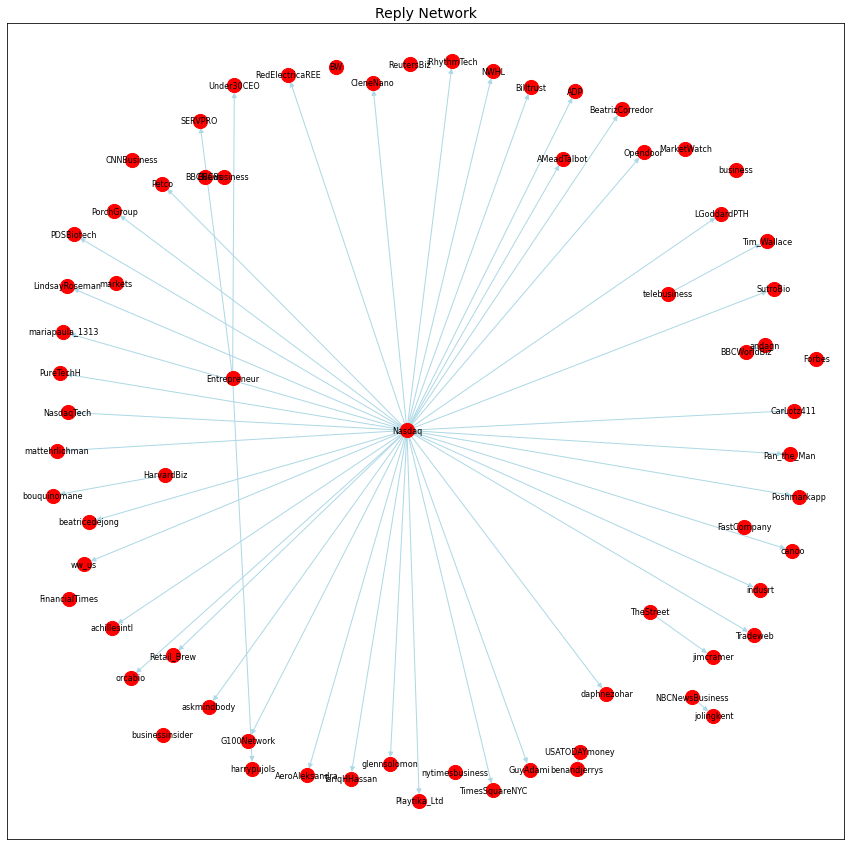

In [23]:
makeGraph(replyNetwork, "red", "Reply Network")

## Mention

In [24]:
mentionNetwork = nx.DiGraph()

In [25]:
mentions = [] 
mentions = pd.json_normalize(networkGraph["entities"])

In [26]:
mentions.head(2)

,hashtags,symbols,user_mentions,urls,media
0,[],[],[],"[{'url': 'https://t.co/HyEGHcXnep', 'expanded_...",NaN
1,[],[],[],"[{'url': 'https://t.co/k8MUYjKu8G', 'expanded_...",NaN


In [27]:
columnsNeeded = ['user_mentions']

In [28]:
mentions.drop(mentions.columns.difference(columnsNeeded), 1, inplace=True)

In [29]:
mentionGraph = pd.concat([users.reset_index(drop=True),mentions.reset_index(drop=True)], axis=1)

In [30]:
mentionGraph = mentionGraph[mentionGraph['user_mentions'].map(lambda drop: len(drop)) > 0]
mentionGraph

,id,screen_name,user_mentions
14,2252205206,BBCWorldBiz,"[{'screen_name': 'robyounguk', 'name': 'Rob Yo..."
16,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."
24,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
25,2735591,FastCompany,"[{'screen_name': '88rising', 'name': '88rising..."
29,3066084185,APBusiness,"[{'screen_name': 'AP', 'name': 'The Associated..."
...,...,...,...
15974,69620713,markets,"[{'screen_name': 'wealth', 'name': 'Bloomberg ..."
15980,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
15987,28140646,WSJbusiness,"[{'screen_name': 'marcelolprince', 'name': 'Ma..."
15990,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."


In [31]:
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            mentionNetwork.add_node(row['user_mentions'][j]['screen_name'])

In [32]:
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            mentionNetwork.add_edge(row['screen_name'], row['user_mentions'][j]['screen_name'])

In [33]:
mentionNetwork.number_of_nodes(), mentionNetwork.number_of_edges()

(1485, 1582)

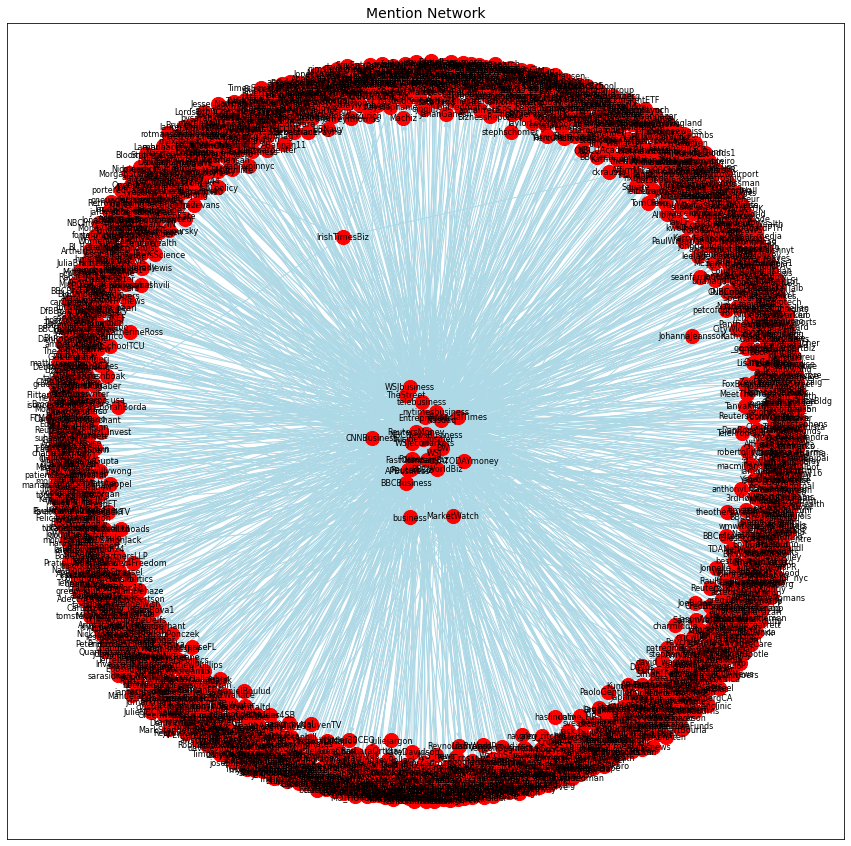

In [34]:
makeGraph(mentionNetwork, "red", "Mention Network")

### ADD EDGE Weights

## User Hashtag Network

In [35]:
userHash = nx.Graph()

In [36]:
userHashtag = [] 
userHashtag = pd.json_normalize(networkGraph["entities"])

In [37]:
userHashtag

,hashtags,symbols,user_mentions,urls,media
0,[],[],[],"[{'url': 'https://t.co/HyEGHcXnep', 'expanded_...",NaN
1,[],[],[],"[{'url': 'https://t.co/k8MUYjKu8G', 'expanded_...",NaN
2,[],[],[],"[{'url': 'https://t.co/LEz96dFqJT', 'expanded_...",NaN
3,[],[],[],"[{'url': 'https://t.co/Mrc8LTN8c7', 'expanded_...",NaN
4,[],[],[],"[{'url': 'https://t.co/TuNwX95jto', 'expanded_...",NaN
...,...,...,...,...,...
15995,[],[],[],"[{'url': 'https://t.co/75XVNb56RZ', 'expanded_...",NaN
15996,[],[],[],"[{'url': 'https://t.co/sUJUI29WIG', 'expanded_...",NaN
15997,[],[],[],"[{'url': 'https://t.co/gPKi0vM3WK', 'expanded_...","[{'id': 1235482704235442177, 'id_str': '123548..."
15998,[],[],[],"[{'url': 'https://t.co/QQwuikIdRo', 'expanded_...",NaN


In [38]:
columnsNeeded = ['hashtags']

In [39]:
userHashtag.drop(userHashtag.columns.difference(columnsNeeded), 1, inplace=True)

In [40]:
userHashtag

,hashtags
0,[]
1,[]
2,[]
3,[]
4,[]
...,...
15995,[]
15996,[]
15997,[]
15998,[]


In [41]:
userHashtag = pd.concat([users.reset_index(drop=True),userHashtag.reset_index(drop=True)], axis=1)

In [42]:
userHashtag

,id,screen_name,hashtags
0,3108351,WSJ,[]
1,14800270,HarvardBiz,[]
2,11014272,ftfinancenews,[]
3,3108351,WSJ,[]
4,1754641,nytimesbusiness,[]
...,...,...,...
15995,67358777,BW,[]
15996,11014272,ftfinancenews,[]
15997,95213382,IndoBusiness,[]
15998,624413,MarketWatch,[]


In [43]:
userHashtag = userHashtag[userHashtag['hashtags'].map(lambda drop: len(drop)) > 0]
userHashtag

,id,screen_name,hashtags
55,224240358,ReutersMoney,"[{'text': 'AppleEvent', 'indices': [53, 64]}]"
108,95213382,IndoBusiness,"[{'text': 'sponsored', 'indices': [55, 65]}]"
127,621523,BBCBusiness,"[{'text': 'Millionby30', 'indices': [137, 149]}]"
135,2252205206,BBCWorldBiz,"[{'text': 'Automotive', 'indices': [35, 46]}]"
160,91478624,Forbes,"[{'text': 'DecadeofU30', 'indices': [138, 150]}]"
...,...,...,...
15838,69620713,markets,"[{'text': 'crypto', 'indices': [17, 24]}, {'te..."
15840,621523,BBCBusiness,"[{'text': 'NYE', 'indices': [33, 37]}]"
15868,224240358,ReutersMoney,"[{'text': 'REIT', 'indices': [106, 111]}, {'te..."
15902,621523,BBCBusiness,"[{'text': 'WorldBusinessReport', 'indices': [1..."


In [44]:
usernames = []
for i, row in userHashtag.iterrows():
        usernames.append(row['screen_name'])

In [45]:
hashtags = []
for i, row in userHashtag.iterrows():
    for j in range(len(row['hashtags'])):
        hashtags.append(row['hashtags'][j]['text'])

In [68]:
pairs = []
for i, row in userHashtag.iterrows():
    for j in range(len(row['hashtags'])):
        for k in row['hashtags'][j]:
            pairs.append((row['screen_name'], row['hashtags'][j]['text']))

In [69]:
# Create the bipartite network
b = nx.Graph()
user_nodes, htag_nodes = set(), set()
for p in pairs:
    user = p[0]
    htag = p[1]    
    # create the nodes, users and hashtags
    if not user in user_nodes:
        b.add_node(user, bipartite=0)
        user_nodes.add(user)
    if not htag in htag_nodes:
        b.add_node(htag, bipartite=1)
        htag_nodes.add(htag)    
    # create the edge 
    htag_nodes.add(htag)
    b.add_edge( user, htag )
print("Created bipartite network with %d nodes and %d edges" % ( b.number_of_nodes(), b.number_of_edges() ) )

Created bipartite network with 298 nodes and 315 edges


In [70]:
bipartite.is_bipartite(b)

False